In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


#load the data
data = pd.read_csv('train.csv')
print(data.head())
print(data.info())
print(data.describe())



     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null 

In [4]:
#drop id column
data = data.drop('patient_id', axis=1)
data_noimage = data.drop('image_name', axis=1)

In [13]:
data.columns

Index(['image_name', 'sex', 'age_approx', 'anatom_site_general_challenge',
       'diagnosis', 'benign_malignant', 'target'],
      dtype='object')

In [5]:
#encode data_noimage using label encoder
le = LabelEncoder()

for col in data_noimage.columns:
    if data_noimage[col].dtype == 'object':
        data_noimage[col] = le.fit_transform(data_noimage[col])

data_noimage.dropna(inplace=True)

In [6]:
data_noimage.head()

,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,1,45.0,0,8,0,0
1,0,45.0,5,8,0,0
2,0,50.0,1,5,0,0
3,0,45.0,0,8,0,0
4,0,55.0,5,8,0,0


In [7]:
#make a model predicting the diagnosis in data_noimage 
X = data_noimage.drop('diagnosis', axis=1)
y = data_noimage['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8330308529945554


In [8]:
#get better params using a griud search and predict again
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print(accuracy_score(y_test, y_pred))




Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\rapha\anaconda3\envs\basePython\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


{'max_depth': 10, 'n_estimators': 100}
0.8330308529945554


In [9]:
#load the images from C:\Developer\Cancer\test and C:\Developer\Cancer\train
import os

train_path = 'C:/Developer/Cancer/train/'
test_path = 'C:/Developer/Cancer/test/'

train_images = [f for f in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, f))]
test_images = [f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]
print(len(train_images))
print(len(test_images))






33126
10982


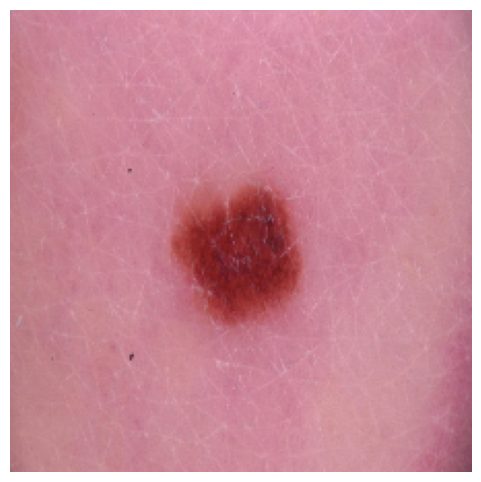

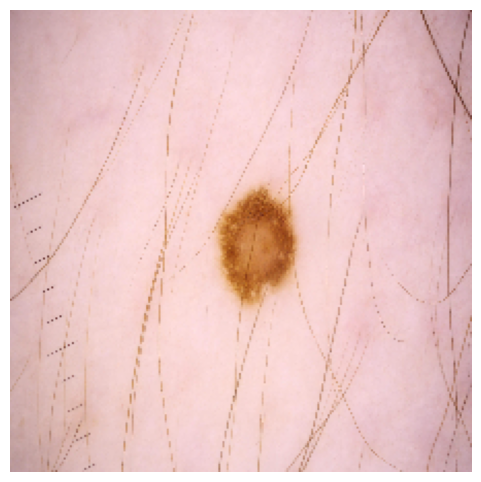

In [10]:
#convert images to rgb
import cv2

def read_image(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def resize_image(image, size):
    return cv2.resize(image, size)

def show_image(image):
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.axis('off')

image_train = read_image(train_path + train_images[1])

image_test = read_image(test_path + test_images[1])

#resize the images
image_resized_train = resize_image(image_train, (224, 224))
show_image(image_resized_train)
 
image_resized_test = resize_image(image_test, (224, 224))
show_image(image_resized_test)





In [11]:
#make labels for the images from train.csv and use them as labels for image_resized_train
data['diagnosis'] = le.fit_transform(data['diagnosis'])
data['diagnosis'].value_counts()

#make a model predicting the diagnosis in data_noimage
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

X = data_noimage.drop('diagnosis', axis=1)
y = data_noimage['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

kf = KFold(n_splits=5)
accuracy = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

print(np.mean(accuracy))


0.8361970411191161


In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import cv2

class CancerDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.images = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = read_image(self.data_path + self.images[idx])
        image = resize_image(image, (224, 224))
        if self.transform:
            image = self.transform(image)
        return image

def read_image(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def resize_image(image, size):
    return cv2.resize(image, size)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CancerDataset(train_path, transform=transform)
test_dataset = CancerDataset(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(loader):
        inputs = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    for i, data in enumerate(loader):
        inputs = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    return running_loss / len(loader)  

n_epochs = 10
for epoch in range(n_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    test_loss = evaluate(model, test_loader, criterion)
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}')

# Save the model
torch.save(model.state_dict(), 'model.pth')

# Make predictions on the test set
model.eval()
predictions = []
for i, data in enumerate(test_loader):
    inputs = data
    inputs = inputs.to(device)
    outputs = model(inputs)
    preds = torch.max(outputs, 1)
    predictions += preds.tolist()

# Save the predictions
predictions = le.inverse_transform(predictions)
submission = pd.DataFrame({'image_name': test_images, 'diagnosis': predictions})
submission.to_csv('submission.csv', index=False)

print(submission.head())


c:\Users\rapha\anaconda3\envs\basePython\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rapha\anaconda3\envs\basePython\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'labels' is not defined